# Import Packages

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, optimizers, losses, callbacks
from tensorflow.keras.layers import Dense, Conv1D, LSTM, InputLayer, Input, BatchNormalization, Dropout, Bidirectional
from tensorflow.keras.losses import mae, mse, BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, f1_score, accuracy_score, mean_squared_log_error, mean_absolute_percentage_error, median_absolute_error, explained_variance_score, balanced_accuracy_score, precision_score, recall_score, matthews_corrcoef
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from category_encoders import TargetEncoder
from mpl_toolkits.mplot3d import Axes3D

# Import Data From Kaggle

In [ ]:
!chmod 600 ~/ /content/drive/MyDrive/Hackathons/kaggle

chmod: cannot access '/content/drive/MyDrive/Hackathons/kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d sujalsuthar/food-delivery-order-history-data

Dataset URL: https://www.kaggle.com/datasets/sujalsuthar/food-delivery-order-history-data
License(s): MIT
 64% 1.00M/1.57M [00:00<00:00, 1.45MB/s]
100% 1.57M/1.57M [00:00<00:00, 2.04MB/s]


In [ ]:
!unzip /content/food-delivery-order-history-data.zip

Archive:  /content/food-delivery-order-history-data.zip
  inflating: order_history_kaggle_data.csv  


In [ ]:
df = pd.read_csv("/content/order_history_kaggle_data.csv")

In [ ]:
df.head(3)

,Restaurant ID,Restaurant name,Subzone,City,Order ID,Order Placed At,Order Status,Delivery,Distance,Items in order,...,Rating,Review,Cancellation / Rejection reason,Restaurant compensation (Cancellation),Restaurant penalty (Rejection),KPT duration (minutes),Rider wait time (minutes),Order Ready Marked,Customer complaint tag,Customer ID
0,20320607,Swaad,Sector 4,Delhi NCR,6168884918,"11:38 PM, September 10 2024",Delivered,Zomato Delivery,3km,"1 x Grilled Chicken Jamaican Tender, 1 x Grill...",...,NaN,NaN,NaN,NaN,NaN,18.35,11.6,Correctly,NaN,5d6c2b96db963098bc69768bea504c8bf46106a8a5178e...
1,20320607,Swaad,Sector 4,Delhi NCR,6170707559,"11:34 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Fries, 1 x Fried Chicken Angara ...",...,NaN,NaN,NaN,NaN,NaN,16.95,3.6,Correctly,NaN,0781815deb4a10a574e9fee4fa0b86b074d4a0b36175d5...
2,20320607,Swaad,Sector 4,Delhi NCR,6169375019,"03:52 PM, September 10 2024",Delivered,Zomato Delivery,<1km,1 x Bone in Peri Peri Grilled Chicken,...,NaN,NaN,NaN,NaN,NaN,14.05,12.2,Correctly,NaN,f93362f5ce5382657482d164e368186bcec9c6225fd93d...


In [ ]:
len(df)

21321

In [ ]:
df.isnull().sum()

,0
Restaurant ID,0
Restaurant name,0
Subzone,0
City,0
Order ID,0
Order Placed At,0
Order Status,0
Delivery,0
Distance,0
Items in order,0


# Evaluate Model Function

In [ ]:
def evaluate_model(y_true, y_pred, task_type="regression"):
    metrics = {}

    if task_type == "regression":
        metrics["MAE"] = mean_absolute_error(y_true, y_pred)
        metrics["MSE"] = mean_squared_error(y_true, y_pred)
        metrics["RMSE"] = np.sqrt(metrics["MSE"])
        metrics["MSLE"] = mean_squared_log_error(y_true, np.maximum(y_pred, 0))
        metrics["MAPE"] = mean_absolute_percentage_error(y_true, y_pred)
        metrics["MedAE"] = median_absolute_error(y_true, y_pred)
        metrics["R2"] = r2_score(y_true, y_pred)
        metrics["Explained Variance"] = explained_variance_score(y_true, y_pred)

    elif task_type == "classification":
        metrics["Accuracy"] = accuracy_score(y_true, y_pred)
        metrics["Balanced Accuracy"] = balanced_accuracy_score(y_true, y_pred)
        metrics["F1 Score"] = f1_score(y_true, y_pred, average="weighted")
        metrics["Precision"] = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        metrics["Recall"] = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        metrics["MCC"] = matthews_corrcoef(y_true, y_pred)

    return metrics

# Different Type Of Plot Prediction Function

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_predictions(y_true, y_pred, model_name="Model"):
    """
    Enhanced plot of predicted vs actual values with additional elements for better visualization.

    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted values
    - model_name: str, optional name for the model
    """
    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 5))

    errors = y_pred - y_true
    plt.scatter(y_true, y_pred, c=errors, cmap="coolwarm", alpha=0.7, edgecolors='k', s=100, label="Predictions")

    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color="red", linestyle="--", label="Perfect Fit")

    p = np.poly1d(np.polyfit(y_true, y_pred, 1))
    plt.plot(np.sort(y_true), p(np.sort(y_true)), color="green", label="Best Fit Line (Linear Regression)")

    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.title(f"{model_name} - Actual vs. Predicted", fontsize=14)

    plt.xlim([min(y_true) - 1, max(y_true) + 1])
    plt.ylim([min(y_pred) - 1, max(y_pred) + 1])

    plt.grid(True)

    plt.legend()

    for i in range(len(y_true)):
        if abs(errors[i]) > np.percentile(errors, 95):  # Highlight large errors (outliers)
            plt.annotate(f"{i}", (y_true[i], y_pred[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)

    plt.show()

In [ ]:
def plot_line_predictions(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(8, 5))
    plt.plot(y_true, label="Actual Values", color="blue", linestyle='-', marker='o')
    plt.plot(y_pred, label="Predicted Values", color="red", linestyle='--', marker='x')
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.title(f"{model_name} - Prediction vs Actual (Line Plot)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Model That Will Experiment With This Data

1. Linear Regression
2. Decision Tree Regression
3. Random Forest Regrassion
4. Support Vector Matchine
5. Feed Forward Neural Network
6. Deep Neural Network
7. Recurrent Neural Network ( LSTM )
8. Recurrent Neural Network ( Bidirectional )

# Preprocessing The Dataset

In [ ]:
df.head()

,Restaurant ID,Restaurant name,Subzone,City,Order ID,Order Placed At,Order Status,Delivery,Distance,Items in order,...,Rating,Review,Cancellation / Rejection reason,Restaurant compensation (Cancellation),Restaurant penalty (Rejection),KPT duration (minutes),Rider wait time (minutes),Order Ready Marked,Customer complaint tag,Customer ID
0,20320607,Swaad,Sector 4,Delhi NCR,6168884918,"11:38 PM, September 10 2024",Delivered,Zomato Delivery,3km,"1 x Grilled Chicken Jamaican Tender, 1 x Grill...",...,NaN,NaN,NaN,NaN,NaN,18.35,11.6,Correctly,NaN,5d6c2b96db963098bc69768bea504c8bf46106a8a5178e...
1,20320607,Swaad,Sector 4,Delhi NCR,6170707559,"11:34 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Fries, 1 x Fried Chicken Angara ...",...,NaN,NaN,NaN,NaN,NaN,16.95,3.6,Correctly,NaN,0781815deb4a10a574e9fee4fa0b86b074d4a0b36175d5...
2,20320607,Swaad,Sector 4,Delhi NCR,6169375019,"03:52 PM, September 10 2024",Delivered,Zomato Delivery,<1km,1 x Bone in Peri Peri Grilled Chicken,...,NaN,NaN,NaN,NaN,NaN,14.05,12.2,Correctly,NaN,f93362f5ce5382657482d164e368186bcec9c6225fd93d...
3,20320607,Swaad,Sector 4,Delhi NCR,6151677434,"03:45 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Fried Chicken Ghostbuster Tender, 1 x Anga...",...,4.0,NaN,NaN,NaN,NaN,19.00,3.3,Correctly,NaN,1ed226d1b8a5f7acee12fc1d6676558330a3b2b742af5d...
4,20320607,Swaad,Sector 4,Delhi NCR,6167540897,"03:04 PM, September 10 2024",Delivered,Zomato Delivery,2km,"1 x Peri Peri Krispers, 1 x Fried Chicken Anga...",...,NaN,NaN,NaN,NaN,NaN,15.97,1.0,Correctly,NaN,d21a2ac6ea06b31cc3288ab20c4ef2f292066c096f2c5f...


## Filter Data By Problem ( Predicting KPT duration (minutes) )

In [ ]:
df.columns

Index(['Restaurant ID', 'Restaurant name', 'Subzone', 'City', 'Order ID',
       'Order Placed At', 'Order Status', 'Delivery', 'Distance',
       'Items in order', 'Instructions', 'Discount construct', 'Bill subtotal',
       'Packaging charges', 'Restaurant discount (Promo)',
       'Restaurant discount (Flat offs, Freebies & others)', 'Gold discount',
       'Brand pack discount', 'Total', 'Rating', 'Review',
       'Cancellation / Rejection reason',
       'Restaurant compensation (Cancellation)',
       'Restaurant penalty (Rejection)', 'KPT duration (minutes)',
       'Rider wait time (minutes)', 'Order Ready Marked',
       'Customer complaint tag', 'Customer ID'],
      dtype='object')

In [ ]:
filter_df = df[[
    "Restaurant ID",
    "Restaurant name",
    "Subzone",
    "City",
    "Order Placed At",
    "Distance",
    "Items in order",
    "Bill subtotal",
    "Packaging charges",
    "Total",
    "Rider wait time (minutes)",
    "Order Ready Marked",
    "KPT duration (minutes)"
    ]]

In [ ]:
filter_df.head()

,Restaurant ID,Restaurant name,Subzone,City,Order Placed At,Distance,Items in order,Bill subtotal,Packaging charges,Total,Rider wait time (minutes),Order Ready Marked,KPT duration (minutes)
0,20320607,Swaad,Sector 4,Delhi NCR,"11:38 PM, September 10 2024",3km,"1 x Grilled Chicken Jamaican Tender, 1 x Grill...",715.0,31.75,666.75,11.6,Correctly,18.35
1,20320607,Swaad,Sector 4,Delhi NCR,"11:34 PM, September 10 2024",2km,"1 x Peri Peri Fries, 1 x Fried Chicken Angara ...",1179.0,50.20,1054.20,3.6,Correctly,16.95
2,20320607,Swaad,Sector 4,Delhi NCR,"03:52 PM, September 10 2024",<1km,1 x Bone in Peri Peri Grilled Chicken,310.0,11.50,241.50,12.2,Correctly,14.05
3,20320607,Swaad,Sector 4,Delhi NCR,"03:45 PM, September 10 2024",2km,"1 x Fried Chicken Ghostbuster Tender, 1 x Anga...",620.0,27.00,567.00,3.3,Correctly,19.00
4,20320607,Swaad,Sector 4,Delhi NCR,"03:04 PM, September 10 2024",2km,"1 x Peri Peri Krispers, 1 x Fried Chicken Anga...",584.0,25.20,529.20,1.0,Correctly,15.97


## Feature Engineering

In [ ]:
filter_df = filter_df.copy()

In [ ]:
filter_df['Order Placed At'] = pd.to_datetime(filter_df['Order Placed At'], format='%I:%M %p, %B %d %Y', errors='coerce')

filter_df.loc[:, "Time"] = filter_df["Order Placed At"].dt.strftime("%I:%M %p")
filter_df.loc[:, "Year"] =filter_df["Order Placed At"].dt.year
filter_df.loc[:, "Month"] = filter_df["Order Placed At"].dt.month
filter_df.loc[:, "Day"] = filter_df["Order Placed At"].dt.day

filter_df = filter_df.drop(columns=["Order Placed At"])

In [ ]:
split_items_order = filter_df["Items in order"].str.split(",", expand = True)
filter_df[["Item 1", "Item 2"]] = split_items_order[[0, 1]]

filter_df = filter_df.drop(columns=["Items in order"])

In [ ]:
filter_df["KPT duration (minutes)"] = filter_df["KPT duration (minutes)"].fillna(filter_df["KPT duration (minutes)"].median())
filter_df["Rider wait time (minutes)"] = filter_df["Rider wait time (minutes)"].fillna(filter_df["Rider wait time (minutes)"].median())

In [ ]:
filter_df.head()

,Restaurant ID,Restaurant name,Subzone,City,Distance,Bill subtotal,Packaging charges,Total,Rider wait time (minutes),Order Ready Marked,KPT duration (minutes),Time,Year,Month,Day,Item 1,Item 2
0,20320607,Swaad,Sector 4,Delhi NCR,3km,715.0,31.75,666.75,11.6,Correctly,18.35,11:38 PM,2024,9,10,1 x Grilled Chicken Jamaican Tender,1 x Grilled Chicken Peri Peri Tangdi
1,20320607,Swaad,Sector 4,Delhi NCR,2km,1179.0,50.20,1054.20,3.6,Correctly,16.95,11:34 PM,2024,9,10,1 x Peri Peri Fries,1 x Fried Chicken Angara Tender
2,20320607,Swaad,Sector 4,Delhi NCR,<1km,310.0,11.50,241.50,12.2,Correctly,14.05,03:52 PM,2024,9,10,1 x Bone in Peri Peri Grilled Chicken,None
3,20320607,Swaad,Sector 4,Delhi NCR,2km,620.0,27.00,567.00,3.3,Correctly,19.00,03:45 PM,2024,9,10,1 x Fried Chicken Ghostbuster Tender,1 x Angara Grilled Paneer (8 pcs)
4,20320607,Swaad,Sector 4,Delhi NCR,2km,584.0,25.20,529.20,1.0,Correctly,15.97,03:04 PM,2024,9,10,1 x Peri Peri Krispers,1 x Fried Chicken Angara Tender


## Encoding String Values

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
string_cols = ["Restaurant name", "Subzone", "City", "Distance", "Order Ready Marked", "Time", "Item 1", "Item 2"]

In [ ]:
for col in string_cols:
    if filter_df[col].dtype == 'object':
        filter_df[col] = label_encoder.fit_transform(filter_df[col])

In [ ]:
filter_df.head()

,Restaurant ID,Restaurant name,Subzone,City,Distance,Bill subtotal,Packaging charges,Total,Rider wait time (minutes),Order Ready Marked,KPT duration (minutes),Time,Year,Month,Day,Item 1,Item 2
0,20320607,3,4,0,14,715.0,31.75,666.75,11.6,0,18.35,860,2024,9,10,120,105
1,20320607,3,4,0,13,1179.0,50.20,1054.20,3.6,0,16.95,852,2024,9,10,194,68
2,20320607,3,4,0,21,310.0,11.50,241.50,12.2,0,14.05,345,2024,9,10,35,331
3,20320607,3,4,0,13,620.0,27.00,567.00,3.3,0,19.00,331,2024,9,10,93,13
4,20320607,3,4,0,13,584.0,25.20,529.20,1.0,0,15.97,249,2024,9,10,199,68


## Split Into Featurs And Label

In [ ]:
target_column = "KPT duration (minutes)"
feature_columns = [col for col in filter_df.columns if col != target_column]

In [ ]:
filter_df.isnull().sum()

,0
Restaurant ID,0
Restaurant name,0
Subzone,0
City,0
Distance,0
Bill subtotal,0
Packaging charges,0
Total,0
Rider wait time (minutes),0
Order Ready Marked,0


In [ ]:
X = filter_df[feature_columns].values
y = filter_df[target_column].values

In [ ]:
X[:2]

array([[2.0320607e+07, 3.0000000e+00, 4.0000000e+00, 0.0000000e+00,
        1.4000000e+01, 7.1500000e+02, 3.1750000e+01, 6.6675000e+02,
        1.1600000e+01, 0.0000000e+00, 8.6000000e+02, 2.0240000e+03,
        9.0000000e+00, 1.0000000e+01, 1.2000000e+02, 1.0500000e+02],
       [2.0320607e+07, 3.0000000e+00, 4.0000000e+00, 0.0000000e+00,
        1.3000000e+01, 1.1790000e+03, 5.0200000e+01, 1.0542000e+03,
        3.6000000e+00, 0.0000000e+00, 8.5200000e+02, 2.0240000e+03,
        9.0000000e+00, 1.0000000e+01, 1.9400000e+02, 6.8000000e+01]])

In [ ]:
y[:2]

array([18.35, 16.95])

## Split Into Train, Test And Validation Set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(17056, 17056, 4265, 4265)

## Normalized Data

In [ ]:
min_max_scaler = MinMaxScaler()

In [ ]:
X_train = min_max_scaler.fit_transform(X_train.reshape(-1, 16)).reshape(-1, 1, 16)
X_test = min_max_scaler.transform(X_test.reshape(-1, 16)).reshape(-1, 1, 16)

In [ ]:
X_train[0]

array([[0.28214193, 0.        , 0.57142857, 0.        , 0.61904762,
        0.02551466, 0.02976783, 0.02572856, 0.0191458 , 0.        ,
        0.62720157, 0.        , 0.90909091, 0.        , 0.42239186,
        1.        ]])

In [ ]:
X_test[0]

array([[0.28214193, 0.        , 0.57142857, 0.        , 0.47619048,
        0.01303805, 0.01401327, 0.00990841, 0.00147275, 1.        ,
        0.62818004, 0.        , 1.        , 0.73333333, 0.13740458,
        1.        ]])

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Model 1: Linear Regression

In [ ]:
model_1 = LinearRegression()

In [ ]:
model_1.fit(
    X_train,
    y_train
)

LinearRegression()

In [ ]:
model_1_preds = model_1.predict(X_test)

In [ ]:
model_1_preds[:10]

array([ 8.09515174, 24.73950132, 12.57030408, 13.0161902 , 14.59557443,
       16.63623135, 30.16675335, 14.65241337, 12.91412766, 13.59779238])

In [ ]:
y_test[:10]

array([16.33, 16.65, 13.78, 12.07, 17.87, 15.05, 36.12, 10.8 , 12.73,
       16.22])

In [ ]:
model_1_results = evaluate_model(y_test, model_1_preds)
model_1_results

{'MAE': 3.5325568441860082,
 'MSE': 24.940583649777665,
 'RMSE': 4.994054830473697,
 'MSLE': 0.07626574695489739,
 'MAPE': 0.3144515184712782,
 'MedAE': 2.7714972088301018,
 'R2': 0.3588482928683826,
 'Explained Variance': 0.3589593223673866}

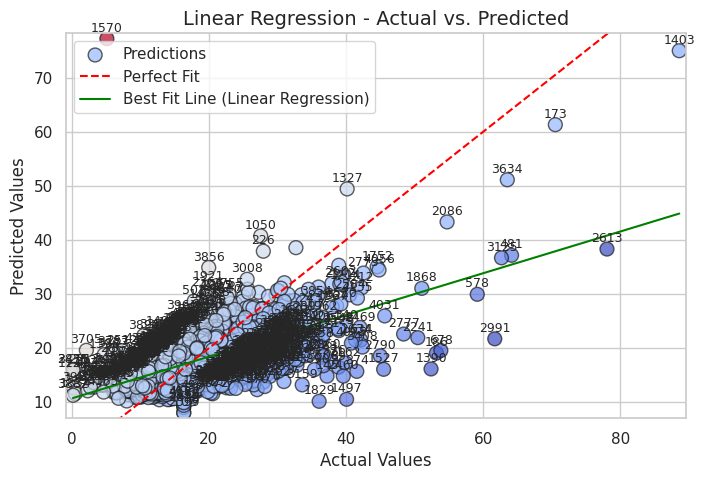

In [ ]:
plot_predictions(y_test, model_1_preds, "Linear Regression")

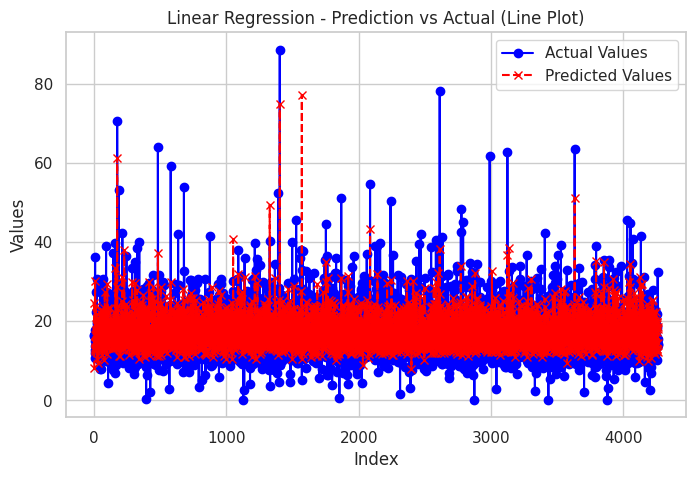

In [ ]:
plot_line_predictions(y_test, model_1_preds, "Linear Regression")

# Model 2: Decision Tree Regression

In [ ]:
model_2 = DecisionTreeRegressor()

In [ ]:
model_2.fit(
    X_train,
    y_train
)

DecisionTreeRegressor()

In [ ]:
model_2_preds = model_2.predict(X_test)

In [ ]:
model_2_preds[:10]

array([13.1 , 25.49, 11.02, 11.13,  9.38, 21.08, 23.22, 11.77, 10.28,
       19.28])

In [ ]:
y_test[:10]

array([16.33, 16.65, 13.78, 12.07, 17.87, 15.05, 36.12, 10.8 , 12.73,
       16.22])

In [ ]:
model_2_results = evaluate_model(y_test, model_2_preds)

In [ ]:
model_2_results

{'MAE': 4.528070339976553,
 'MSE': 41.61005270808909,
 'RMSE': 6.450585454676893,
 'MSLE': 0.12495363212215957,
 'MAPE': 0.3245608473062565,
 'MedAE': 3.34,
 'R2': -0.06967650405670156,
 'Explained Variance': -0.06904198670125195}

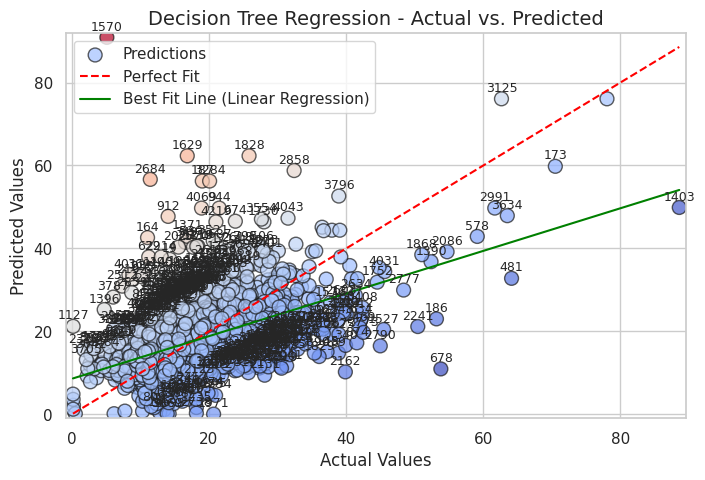

In [ ]:
plot_predictions(y_test, model_2_preds, "Decision Tree Regression")

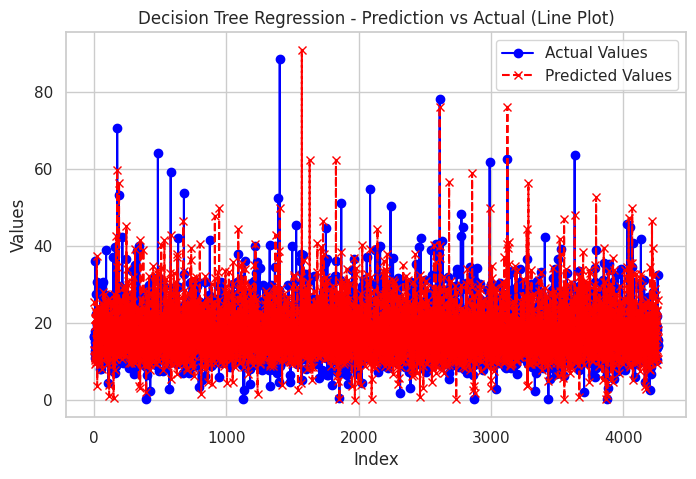

In [ ]:
plot_line_predictions(y_test, model_2_preds, "Decision Tree Regression")

# Model 3: Random Forest Regression

In [ ]:
model_3 = RandomForestRegressor()

In [ ]:
model_3.fit(
    X_train,
    y_train
)

RandomForestRegressor()

In [ ]:
model_3_preds = model_3.predict(X_test)
model_3_preds[:10]

array([10.8843, 22.9703, 14.2492, 14.0453, 11.8202, 16.1   , 27.3042,
       12.3712, 15.0386, 14.9322])

In [ ]:
y_test[:10]

array([16.33, 16.65, 13.78, 12.07, 17.87, 15.05, 36.12, 10.8 , 12.73,
       16.22])

In [ ]:
model_3_results = evaluate_model(y_test, model_3_preds)
model_3_results

{'MAE': 3.196758633059789,
 'MSE': 20.39877226481156,
 'RMSE': 4.5165000016397165,
 'MSLE': 0.06295540454584608,
 'MAPE': 0.2739136799682973,
 'MedAE': 2.412200000000004,
 'R2': 0.47560538900661964,
 'Explained Variance': 0.47640164703806664}

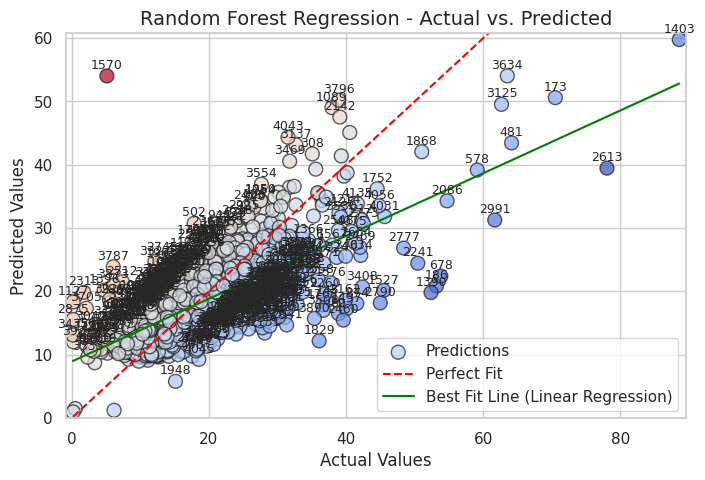

In [ ]:
plot_predictions(y_test, model_3_preds, "Random Forest Regression")

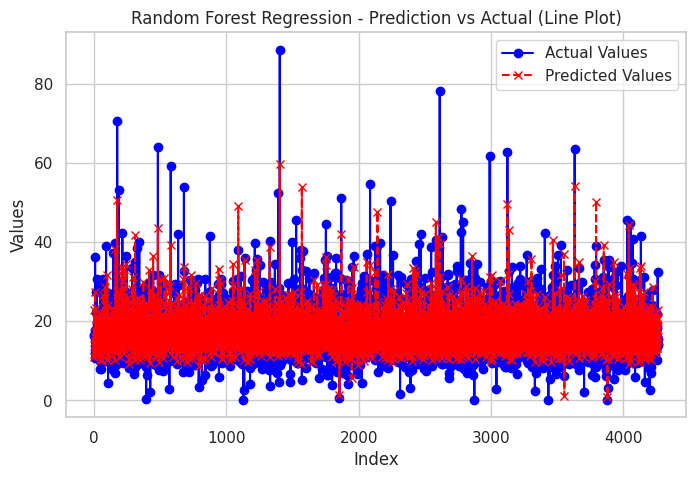

In [ ]:
plot_line_predictions(y_test, model_3_preds, "Random Forest Regression")

# Model 4: Support Vector Matchine

In [ ]:
model_4 = SVR()

In [ ]:
model_4.fit(
    X_train,
    y_train
)

SVR()

In [ ]:
model_4_preds = model_4.predict(X_test)

In [ ]:
model_4_preds[:10]

array([13.10575718, 23.88905703, 15.49184834, 12.92571974, 12.57735469,
       15.80134319, 25.27378482, 14.38484985, 14.98444895, 14.35275603])

In [ ]:
y_test[:10]

array([16.33, 16.65, 13.78, 12.07, 17.87, 15.05, 36.12, 10.8 , 12.73,
       16.22])

In [ ]:
model_4_results = evaluate_model(y_test, model_4_preds)

In [ ]:
model_4_results

{'MAE': 3.26652688427041,
 'MSE': 23.572668315431372,
 'RMSE': 4.855169236538658,
 'MSLE': 0.06793841644494784,
 'MAPE': 0.28913390399259764,
 'MedAE': 2.3534536130935475,
 'R2': 0.3940135185159974,
 'Explained Variance': 0.4040863148380168}

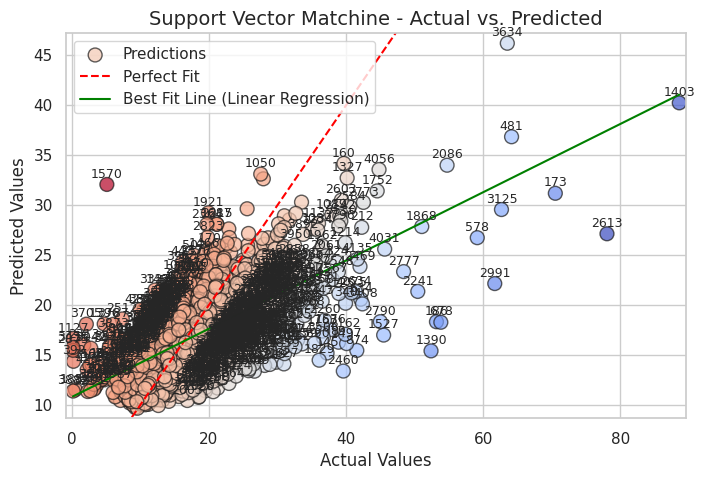

In [ ]:
plot_predictions(y_test, model_4_preds, "Support Vector Matchine")

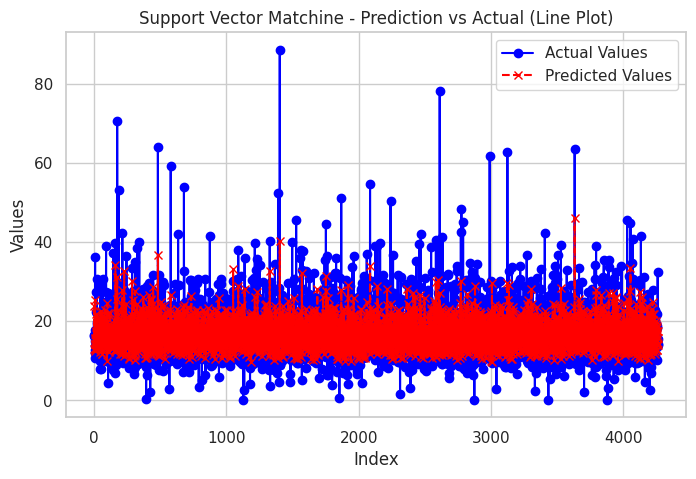

In [ ]:
plot_line_predictions(y_test, model_4_preds, "Support Vector Matchine")

# Model 5: Feed Forward Neural Network

In [ ]:
model_5 = Sequential([
    Dense(32, activation = "relu"),
    Dense(1, activation = "linear")
])

In [ ]:
model_5.compile(
    loss = losses.mae,
    optimizer = optimizers.Adam(),
    metrics = ["mae"]
)

In [ ]:
model_5.fit(
    X_train,
    y_train,
    epochs = 50,
    batch_size = 32
)

Epoch 1/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 11.5731 - mae: 11.5731
Epoch 2/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.3675 - mae: 4.3675
Epoch 3/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.9289 - mae: 3.9289
Epoch 4/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.7003 - mae: 3.7003
Epoch 5/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5566 - mae: 3.5566
Epoch 6/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4612 - mae: 3.4612
Epoch 7/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4666 - mae: 3.4666
Epoch 8/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4372 - mae: 3.4372
Epoch 9/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4583 - mae: 3.4583
Epoch 10/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4386 - mae: 3.4386
Epoch 11/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.4251 - mae: 3.4251
Epoch 12/50
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.4231 - mae: 3.4231
Epoch 13/50
533/533 ━━━

In [ ]:
model_5_preds = model_5.predict(X_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [ ]:
model_5_preds[:10]

array([[12.565684 ],
       [23.6987   ],
       [14.732134 ],
       [11.234652 ],
       [13.199803 ],
       [15.986191 ],
       [28.722315 ],
       [13.75853  ],
       [15.1837635],
       [14.234783 ]], dtype=float32)

In [ ]:
y_test[:10]

array([16.33, 16.65, 13.78, 12.07, 17.87, 15.05, 36.12, 10.8 , 12.73,
       16.22])

In [ ]:
model_5_results = evaluate_model(y_test, tf.squeeze(model_5_preds).numpy())

In [ ]:
model_5_results

{'MAE': 3.2949064639897587,
 'MSE': 24.10317754386613,
 'RMSE': 4.909498705964402,
 'MSLE': 0.0693300851267193,
 'MAPE': 0.28280723971424454,
 'MedAE': 2.3786772537231453,
 'R2': 0.3803756300753611,
 'Explained Variance': 0.3989885105780504}

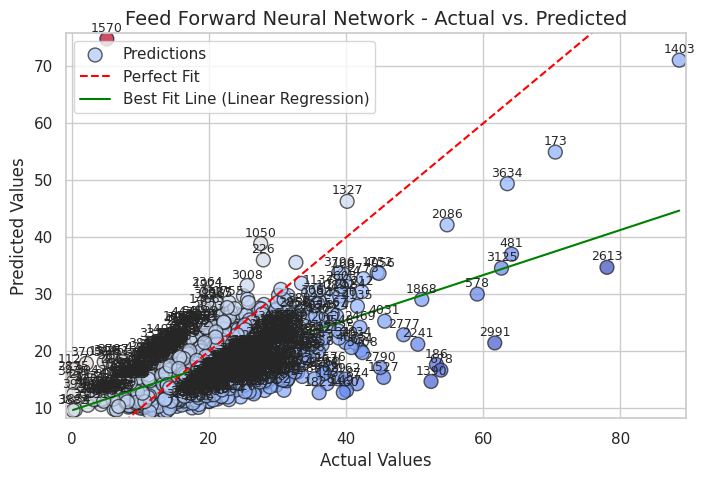

In [ ]:
plot_predictions(y_test, tf.squeeze(model_5_preds).numpy(), "Feed Forward Neural Network")

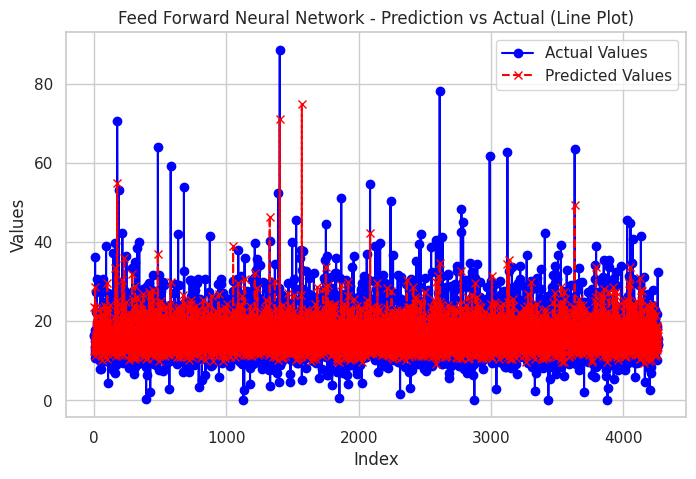

In [ ]:
plot_line_predictions(y_test, tf.squeeze(model_5_preds).numpy(), "Feed Forward Neural Network")

# Model 6: Deep Neural Network

In [ ]:
model_6 = Sequential([
    Dense(1024, activation="relu"),
    Dense(512, activation="relu"),
    Dense(256, activation = "relu"),
    Dense(512, activation = "relu"),
    Dense(126, activation = "relu"),
    Dense(256, activation = "relu"),
    Dense(1),
])

In [ ]:
model_6.compile(
    loss = losses.mse,
    optimizer = optimizers.Adam(learning_rate=0.00001),
    metrics = ["mae"]
)

In [ ]:
model_6.fit(
    X_train,
    y_train,
    epochs = 25,
    batch_size = 32
)

Epoch 1/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 286.8297 - mae: 15.3834
Epoch 2/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 41.9994 - mae: 4.6533
Epoch 3/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 35.9968 - mae: 4.2385
Epoch 4/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 31.4860 - mae: 4.0413
Epoch 5/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 31.9108 - mae: 3.9251
Epoch 6/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 29.1767 - mae: 3.8084
Epoch 7/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 29.4705 - mae: 3.7511
Epoch 8/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 28.0059 - mae: 3.6605
Epoch 9/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 24.6335 - mae: 3.5465
Epoch 10/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 23.4934 - mae: 3.4405
Epoch 11/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 26.2527 - mae: 3.5453
Epoch 12/25
533/533 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 23.6806 - mae

In [ ]:
model_6_preds = model_6.predict(X_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
model_6_preds[:10]

array([[11.330577 ],
       [25.006561 ],
       [15.066346 ],
       [13.12164  ],
       [13.76992  ],
       [15.901672 ],
       [29.756681 ],
       [14.2371235],
       [15.324284 ],
       [13.901087 ]], dtype=float32)

In [ ]:
y_test[:10]

array([16.33, 16.65, 13.78, 12.07, 17.87, 15.05, 36.12, 10.8 , 12.73,
       16.22])

In [ ]:
model_6_results = evaluate_model(y_test, tf.squeeze(model_6_preds).numpy())

In [ ]:
model_6_results

{'MAE': 3.3493817769684515,
 'MSE': 23.377400674575387,
 'RMSE': 4.835018166933335,
 'MSLE': 0.07055777800556907,
 'MAPE': 0.3027660393022521,
 'MedAE': 2.570736694335938,
 'R2': 0.3990332960416726,
 'Explained Variance': 0.39914877770206536}

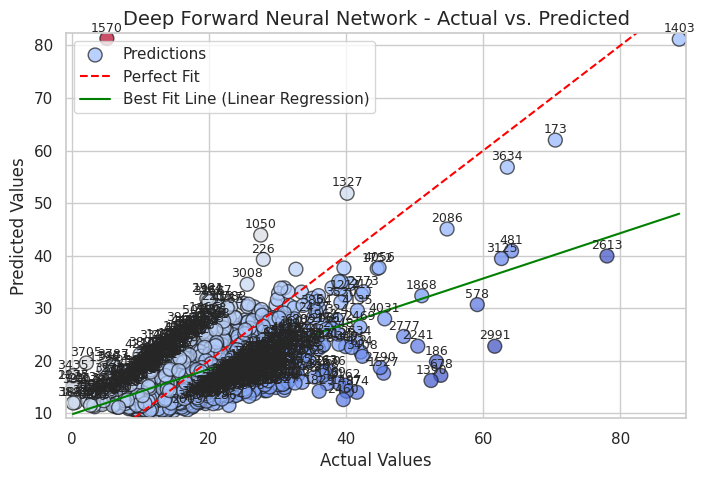

In [ ]:
plot_predictions(y_test, tf.squeeze(model_6_preds).numpy(), "Deep Forward Neural Network")

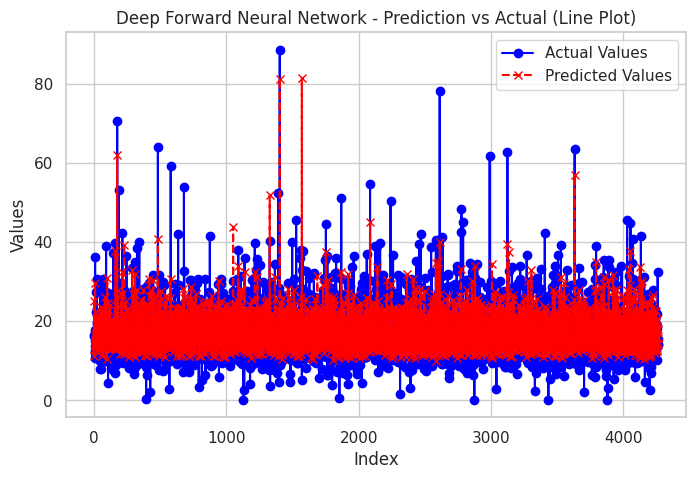

In [ ]:
plot_line_predictions(y_test, tf.squeeze(model_6_preds).numpy(), "Deep Forward Neural Network")

# Model 7: Recurrent Neural Network ( LSTM )

In [ ]:
model_7 = Sequential([
    LSTM(256, return_sequences=True, activation="relu"),
    LSTM(128, activation="relu"),
    Dense(64, activation = "relu"),
    Dense(32, activation = "relu"),
    Dense(1)
])

In [ ]:
model_7.compile(
    loss = losses.mae,
    optimizer = optimizers.Adam(),
    metrics = ["mae"]
)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_train.shape

In [ ]:
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_test.shape

In [ ]:
model_7.fit(
    X_train,
    y_train,
    epochs = 20,
    batch_size = 32
)

Epoch 1/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 7.7547 - mae: 7.7547
Epoch 2/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.4977 - mae: 3.4977
Epoch 3/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.3769 - mae: 3.3769
Epoch 4/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.3718 - mae: 3.3718
Epoch 5/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 3.3026 - mae: 3.3026
Epoch 6/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.3325 - mae: 3.3325
Epoch 7/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 3.2138 - mae: 3.2138
Epoch 8/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 3.2571 - mae: 3.2571
Epoch 9/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.2521 - mae: 3.2521
Epoch 10/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.2374 - mae: 3.2374
Epoch 11/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.2451 - mae: 3.2451
Epoch 12/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 3.2669 - mae: 3.2669
Epoch 13/20
533/533 ━━

In [ ]:
model_7_preds = model_7.predict(X_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
model_6_preds[:10]

array([[11.330577 ],
       [25.006561 ],
       [15.066346 ],
       [13.12164  ],
       [13.76992  ],
       [15.901672 ],
       [29.756681 ],
       [14.2371235],
       [15.324284 ],
       [13.901087 ]], dtype=float32)

In [ ]:
y_test[:10]

array([16.33, 16.65, 13.78, 12.07, 17.87, 15.05, 36.12, 10.8 , 12.73,
       16.22])

In [ ]:
model_7_result = evaluate_model(y_test, tf.squeeze(model_7_preds).numpy())

In [ ]:
model_7_result

{'MAE': 3.330518118971258,
 'MSE': 22.055880478388538,
 'RMSE': 4.696368860980634,
 'MSLE': 0.06989943804621489,
 'MAPE': 0.30994523560693016,
 'MedAE': 2.569616127014161,
 'R2': 0.4330058342024491,
 'Explained Variance': 0.441377090537055}

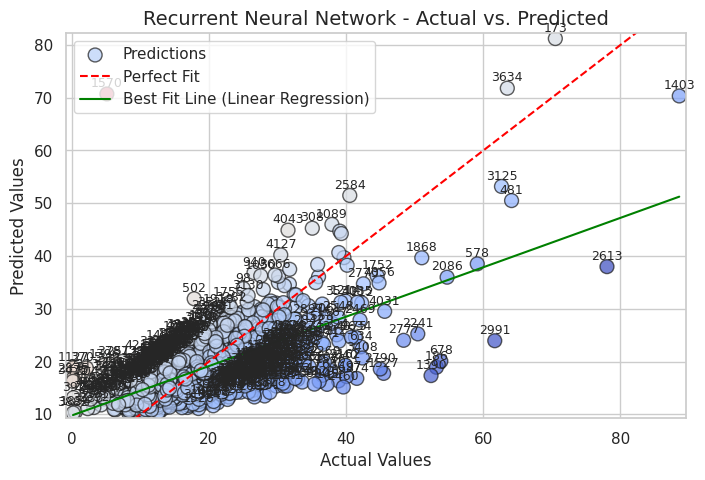

In [ ]:
plot_predictions(y_test, tf.squeeze(model_7_preds).numpy(), "Recurrent Neural Network")

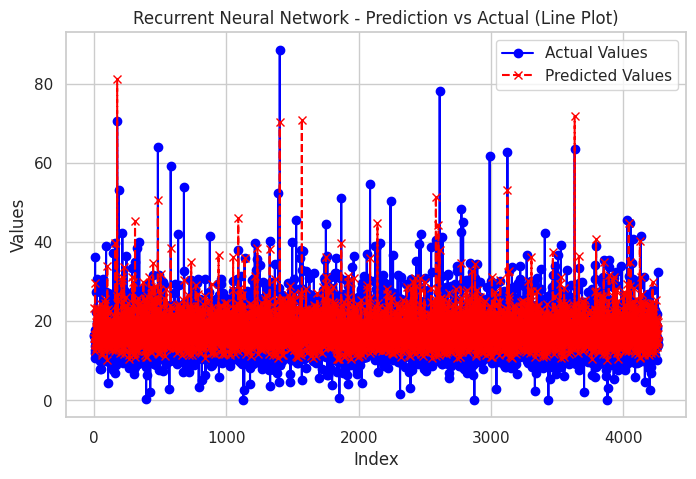

In [ ]:
plot_line_predictions(y_test, tf.squeeze(model_7_preds).numpy(), "Recurrent Neural Network")

# Model 8: Recurrent Neural Network ( Bidirectional )

In [ ]:
model_8 = Sequential([
    Input(shape=(1, 16)),

    Bidirectional(LSTM(256, return_sequences=True, activation = "tanh")),
    Dropout(0.2),

    Bidirectional(LSTM(128, return_sequences=True, activation = "tanh")),
    Dropout(0.2),

    LSTM(64, activation = "tanh"),
    Dropout(0.2),

    Dense(32, activation = "relu"),
    Dense(16, activation = "relu"),
    Dense(1)
])

In [ ]:
model_8.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 1, 512)              │         559,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 1, 256)              │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,300,289 (4.96 MB)

 Trainable params: 1,300,289 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_8.compile(
    loss = losses.mae,
    optimizer = optimizers.Adam(0.0005),
    metrics = ["mae", "mse"]
)

## Defined Callbacks

In [ ]:
early_stoping = callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True
)

## Fit The Model

In [ ]:
history_model_8 = model_8.fit(
    X_train,
    y_train,
    epochs = 200,
    batch_size = 32,
    validation_data = (X_test, y_test),
    callbacks = [early_stoping],
)

Epoch 1/200
533/533 ━━━━━━━━━━━━━━━━━━━━ 51s 24ms/step - loss: 8.6529 - mae: 8.6529 - mse: 134.7564 - val_loss: 4.2894 - val_mae: 4.2894 - val_mse: 40.3186
Epoch 2/200
533/533 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 4.3918 - mae: 4.3918 - mse: 39.9503 - val_loss: 4.3034 - val_mae: 4.3034 - val_mse: 39.1701
Epoch 3/200
533/533 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 4.3844 - mae: 4.3844 - mse: 39.5274 - val_loss: 3.6250 - val_mae: 3.6250 - val_mse: 29.6670
Epoch 4/200
533/533 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 3.6656 - mae: 3.6656 - mse: 28.7372 - val_loss: 3.5250 - val_mae: 3.5250 - val_mse: 26.3826
Epoch 5/200
533/533 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 3.5441 - mae: 3.5441 - mse: 26.3667 - val_loss: 3.4802 - val_mae: 3.4802 - val_mse: 27.1851
Epoch 6/200
533/533 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 3.5646 - mae: 3.5646 - mse: 26.7401 - val_loss: 3.4391 - val_mae: 3.4391 - val_mse: 25.3341
Epoch 7/200
533/533 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 3.5367

In [ ]:
model_8_preds = model_8.predict(X_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


In [ ]:
model_8_preds[:10]

array([[15.302628],
       [21.589745],
       [15.473329],
       [12.258106],
       [12.992672],
       [15.432193],
       [25.908123],
       [14.082376],
       [15.728445],
       [14.040708]], dtype=float32)

In [ ]:
y_test[:10]

array([16.33, 16.65, 13.78, 12.07, 17.87, 15.05, 36.12, 10.8 , 12.73,
       16.22])

In [ ]:
model_8_results = evaluate_model(y_test, tf.squeeze(model_8_preds).numpy())

In [ ]:
model_8_results

{'MAE': 3.1768595712176517,
 'MSE': 21.940397654424643,
 'RMSE': 4.684057819287102,
 'MSLE': 0.06560301879407915,
 'MAPE': 0.2796475945972603,
 'MedAE': 2.2869209289550767,
 'R2': 0.43597457025003117,
 'Explained Variance': 0.4462114880689354}

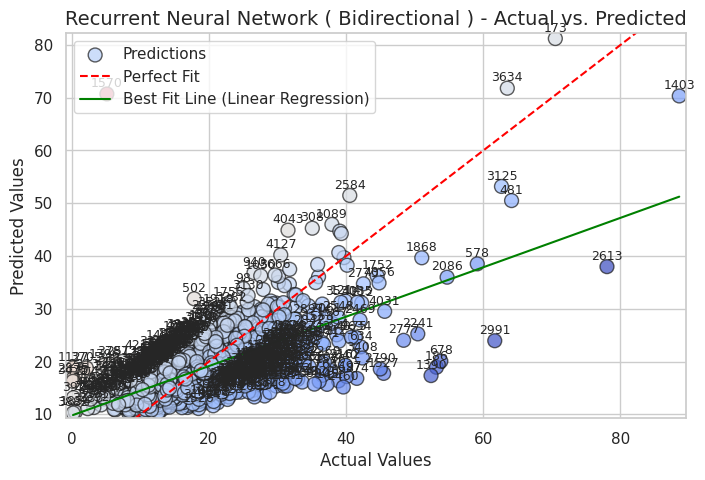

In [ ]:
plot_predictions(y_test, tf.squeeze(model_7_preds).numpy(), "Recurrent Neural Network ( Bidirectional )")

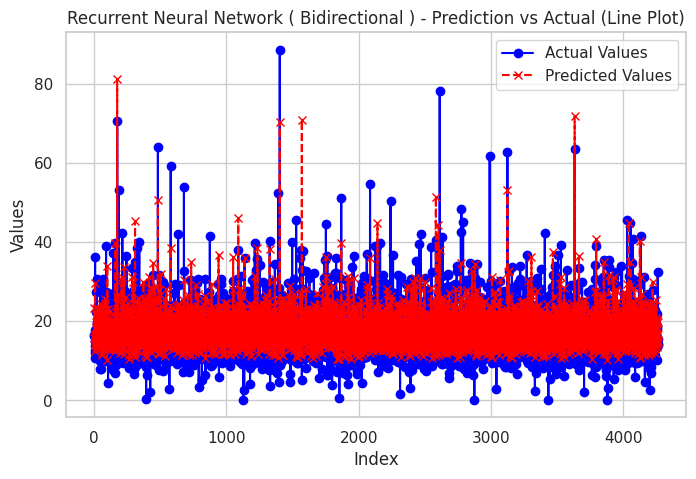

In [ ]:
plot_line_predictions(y_test, tf.squeeze(model_7_preds).numpy(), "Recurrent Neural Network ( Bidirectional )")